In [2]:
import pandas as pd

In [4]:
df_118=pd.read_csv("Dataset_20240601-20250428/01Jul2024-28Avr2025_Salle_118.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'Dataset_20240601-20250428/01Jul2024-28Avr2025_Salle_118.csv'

In [33]:
temp = df_118[['NOVOS3_7_Temperature_u6_108']]
n_days = len(temp) // 144
temp_clean = temp.iloc[:n_days * 144]  # on coupe les valeurs en trop
reshaped = temp_clean.to_numpy().reshape(n_days, 144)
df_temp = pd.DataFrame(reshaped)


Hum = df_118[['THERMOKON_15DF_Humidity_u6_108']]
n_days = len(Hum) // 144
Hum_clean = Hum.iloc[:n_days * 144]  # on coupe les valeurs en trop
reshaped = Hum_clean.to_numpy().reshape(n_days, 144)
df_hum = pd.DataFrame(reshaped)

Co2 = df_118[['NOVOS3_7_Co2_u6_108']]
n_days = len(Co2) // 144
Co2_clean = Co2.iloc[:n_days * 144]  # on coupe les valeurs en trop
reshaped = Co2_clean.to_numpy().reshape(n_days, 144)
df_co2 = pd.DataFrame(reshaped)

Noise = df_118[['DUTCHSS_1F6E_Noise_u6_108']]
n_days = len(Noise) // 144
Noise_clean = Noise.iloc[:n_days * 144]  # on coupe les valeurs en trop
reshaped = Noise_clean.to_numpy().reshape(n_days, 144)
df_Noise = pd.DataFrame(reshaped)

Occ = df_118[['THERMOKON_15DF_OccupancyBinaire_u6_108']]
n_days = len(Occ) // 144
Occ_clean = Occ.iloc[:n_days * 144]  # on coupe les valeurs en trop
reshaped = Occ_clean.to_numpy().reshape(n_days, 144)
df_Occ = pd.DataFrame(reshaped)

In [43]:
df_co2.isna().sum().sum()

0

In [53]:
((df_Occ.sum(axis=1))!=0).sum()

152

In [48]:
len(df_Noise)

252

In [41]:
for df in [df_temp, df_hum, df_co2, df_Noise]:
    df.interpolate(method='linear', axis=1, limit_direction='both', inplace=True)
    df.ffill(axis=1, inplace=True)
    df.bfill(axis=1, inplace=True)
    
for df in [df_temp, df_hum, df_co2, df_Noise]:
    df.dropna(how='all', inplace=True)


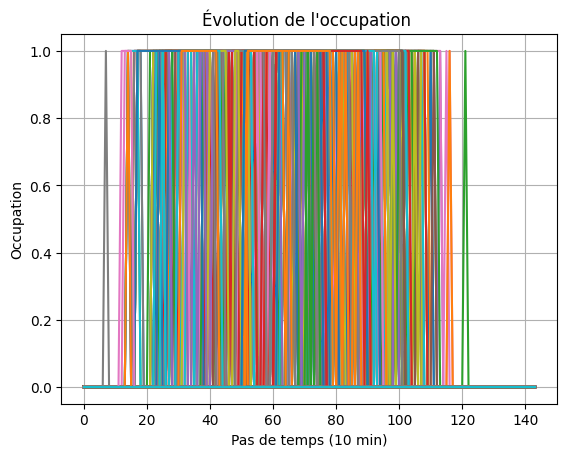

In [143]:
import matplotlib.pyplot as plt
for i in range(df_Occ.shape[0]):
    plt.plot(range(144), df_Occ.iloc[i])  # tracer la 1ère journée
plt.title("Évolution de l'occupation ")
plt.xlabel("Pas de temps (10 min)")
plt.ylabel("Occupation")
plt.grid(True)
plt.show()


In [36]:
df_Occ2=df_Occ.dropna()

In [40]:
df_Occ.fillna(0, inplace=True)


In [112]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed

def train_lstm_model(X, Y, input_shape, test_size=0.2, epochs=20, batch_size=16, threshold=0.5):
    # Split
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=test_size, random_state=42, shuffle=True
    )

    # Modèle
    model = Sequential([
        LSTM(64, activation='tanh', return_sequences=True, input_shape=input_shape),
        TimeDistributed(Dense(1, activation='sigmoid'))
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Entraînement
    history = model.fit(
        X_train, Y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, Y_test),
        verbose=1
    )

    # Prédictions sur le test set
    Y_pred = model.predict(X_test)

    # Optionnel : appliquer le seuil si tu veux des prédictions binaires
    Y_pred_binary = (Y_pred > threshold).astype(int)

    # Retourner les vraies valeurs, prédictions, et X_test pour visualisation
    return X_test, Y_test, Y_pred, Y_pred_binary, history


In [122]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_temp_norm = pd.DataFrame(scaler.fit_transform(df_temp), columns=df_temp.columns, index=df_temp.index)

df_combined = pd.concat([df_temp_norm, df_Occ], axis=1, join='inner')

X = df_combined.iloc[:, :144].to_numpy().reshape((-1, 144, 1))

Y = df_combined.iloc[:, -144:].to_numpy()

X_test, Y_test, Y_pred, Y_pred_binary, history = train_lstm_model(
    X,
    Y,
    input_shape=(144, 1),
    epochs=100,
    batch_size=16,
    threshold=0.5 
)



Epoch 1/100


C:\Users\toubia\anaconda3\envs\notebook\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 224ms/step - accuracy: 0.7049 - loss: 0.6399 - val_accuracy: 0.8451 - val_loss: 0.4866
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.8392 - loss: 0.4875 - val_accuracy: 0.8451 - val_loss: 0.4723
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.8515 - loss: 0.4534 - val_accuracy: 0.8451 - val_loss: 0.4650
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.8396 - loss: 0.4673 - val_accuracy: 0.8451 - val_loss: 0.4606
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.8479 - loss: 0.4517 - val_accuracy: 0.8451 - val_loss: 0.4571
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.8435 - loss: 0.4580 - val_accuracy: 0.8451 - val_loss: 0.4541
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.8442 - loss: 0.4533 - val_accuracy: 0.8451 - val_loss: 0.4513
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.8417 - loss: 0.4536 - val_accuracy: 0.8451 - val

In [98]:
len(df_combined)

250

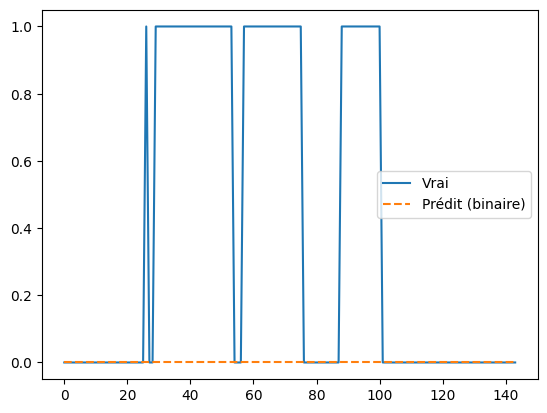

In [109]:


plt.plot(Y_test[3].flatten(), label='Vrai')
plt.plot(Y_pred_binary[3].flatten(), label='Prédit (binaire)', linestyle='--')
plt.legend()
plt.show()


In [115]:
sum_occupation = df_combined.iloc[:, -144:].sum(axis=1)
df_filtered = df_combined[sum_occupation != 0]

X = df_filtered.iloc[:, :144].to_numpy().reshape((-1, 144, 1))
Y = df_filtered.iloc[:, -144:].to_numpy()

X_test2, Y_test2, Y_pred2, Y_pred_binary2, history2 = train_lstm_model(
    X,
    Y,
    input_shape=(144, 1),
    epochs=100,
    batch_size=16,
    threshold=0.5 
)



Epoch 1/100


C:\Users\toubia\anaconda3\envs\notebook\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 319ms/step - accuracy: 0.3669 - loss: 0.7441 - val_accuracy: 0.7180 - val_loss: 0.6116
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.7010 - loss: 0.6189 - val_accuracy: 0.7180 - val_loss: 0.5984
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.6910 - loss: 0.6272 - val_accuracy: 0.7180 - val_loss: 0.5934
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.6950 - loss: 0.6150 - val_accuracy: 0.7180 - val_loss: 0.5928
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.6897 - loss: 0.6167 - val_accuracy: 0.7180 - val_loss: 0.5919
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.7041 - loss: 0.6038 - val_accuracy: 0.7180 - val_loss: 0.5907
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.6932 - loss: 0.6101 - val_accuracy: 0.7180 - val_loss: 0.5883
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.6984 - loss: 0.6053 - val_accuracy: 0.7180 - val_loss: 0.5861
E

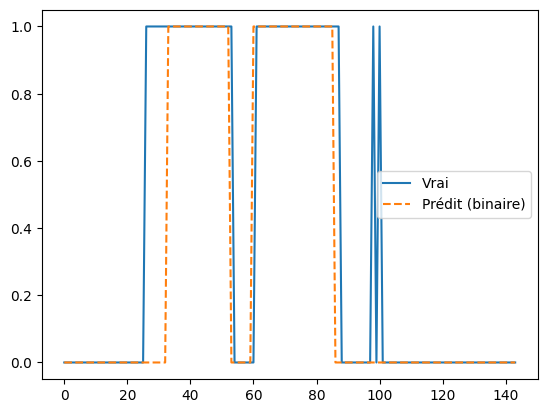

In [93]:


plt.plot(Y_test2[16].flatten(), label='Vrai')
plt.plot(Y_pred_binary2[16].flatten(), label='Prédit (binaire)', linestyle='--')
plt.legend()
plt.show()


In [79]:
len(df_filtered)

151

In [67]:
import numpy as np

In [124]:
scaler = MinMaxScaler()
df_temp_norm = pd.DataFrame(scaler.fit_transform(df_temp), columns=df_temp.columns, index=df_temp.index)
df_Noise_norm = pd.DataFrame(scaler.fit_transform(df_Noise), columns=df_Noise.columns, index=df_Noise.index)

df_combined = pd.concat([df_temp_norm,df_Noise_norm, df_Occ], axis=1, join='inner')

temp = df_combined.iloc[:, 0:144].to_numpy()      
noise = df_combined.iloc[:, 144:288].to_numpy()  
X = np.stack((temp, noise), axis=2)  

Y = df_combined.iloc[:, -144:].to_numpy()

X_test3, Y_test3, Y_pred3, Y_pred_binary3, history3 = train_lstm_model(
    X,
    Y,
    input_shape=(144, 2),
    epochs=100,
    batch_size=16,
    threshold=0.5 
)


Epoch 1/100


C:\Users\toubia\anaconda3\envs\notebook\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 226ms/step - accuracy: 0.6935 - loss: 0.6458 - val_accuracy: 0.8468 - val_loss: 0.4647
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.8707 - loss: 0.4297 - val_accuracy: 0.8468 - val_loss: 0.4276
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.8550 - loss: 0.4149 - val_accuracy: 0.8468 - val_loss: 0.4038
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.8642 - loss: 0.3679 - val_accuracy: 0.8560 - val_loss: 0.3174
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.8901 - loss: 0.2769 - val_accuracy: 0.8829 - val_loss: 0.2815
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.8910 - loss: 0.2698 - val_accuracy: 0.8756 - val_loss: 0.2823
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.8814 - loss: 0.2760 - val_accuracy: 0.8932 - val_loss: 0.2602
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.8950 - loss: 0.2540 - val_accuracy: 0.9043 - val

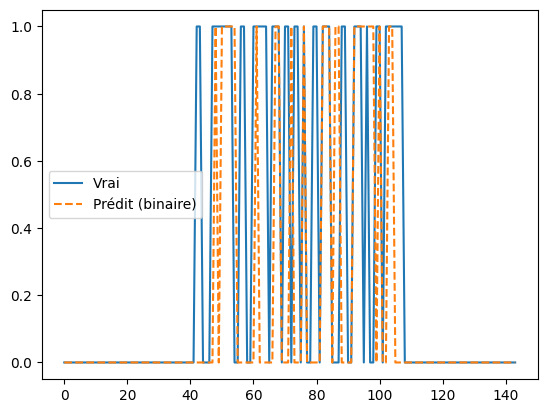

In [73]:
plt.plot(Y_test[8].flatten(), label='Vrai')
plt.plot(Y_pred_binary[8].flatten(), label='Prédit (binaire)', linestyle='--')
plt.legend()
plt.show()


In [130]:
scaler = MinMaxScaler()
df_temp_norm = pd.DataFrame(scaler.fit_transform(df_temp), columns=df_temp.columns, index=df_temp.index)
df_Noise_norm = pd.DataFrame(scaler.fit_transform(df_Noise), columns=df_Noise.columns, index=df_Noise.index)

df_combined = pd.concat([df_temp_norm,df_Noise_norm, df_Occ], axis=1, join='inner')
sum_occupation = df_combined.iloc[:, -144:].sum(axis=1)
df_filtered = df_combined[sum_occupation != 0]

temp = df_filtered.iloc[:, 0:144].to_numpy()      
noise = df_filtered.iloc[:, 144:288].to_numpy()  
X = np.stack((temp, noise), axis=2)  

Y = df_filtered.iloc[:, -144:].to_numpy()

X_test4, Y_test4, Y_pred4, Y_pred_binary4, history4 = train_lstm_model(
    X,
    Y,
    input_shape=(144, 2),
    epochs=100,
    batch_size=16,
    threshold=0.5 
)


Epoch 1/100


C:\Users\toubia\anaconda3\envs\notebook\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 525ms/step - accuracy: 0.7172 - loss: 0.6580 - val_accuracy: 0.7561 - val_loss: 0.6093
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.7264 - loss: 0.6044 - val_accuracy: 0.7561 - val_loss: 0.5463
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.7140 - loss: 0.5683 - val_accuracy: 0.7593 - val_loss: 0.5082
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.7364 - loss: 0.5220 - val_accuracy: 0.7922 - val_loss: 0.4736
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.8093 - loss: 0.4761 - val_accuracy: 0.8218 - val_loss: 0.4356
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.8137 - loss: 0.4506 - val_accuracy: 0.8258 - val_loss: 0.4160
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.8180 - loss: 0.4299 - val_accuracy: 0.8235 - val_loss: 0.4000
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.8305 - loss: 0.3981 - val_accuracy: 0.8348 - val_loss: 0.3959
E

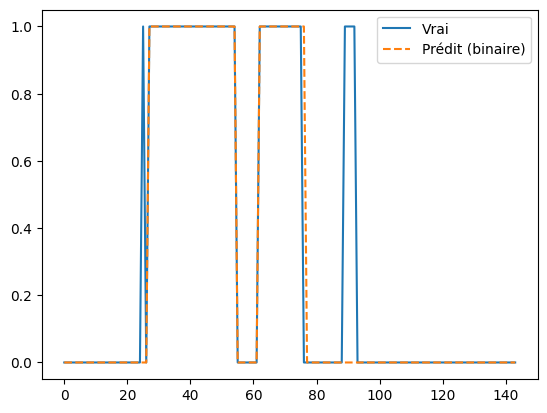

In [131]:
plt.plot(Y_test4[8].flatten(), label='Vrai')
plt.plot(Y_pred_binary4[8].flatten(), label='Prédit (binaire)', linestyle='--')
plt.legend()
plt.show()


In [128]:
scaler = MinMaxScaler()
df_temp_norm = pd.DataFrame(scaler.fit_transform(df_temp), columns=df_temp.columns, index=df_temp.index)
df_hum_norm = pd.DataFrame(scaler.fit_transform(df_hum), columns=df_hum.columns, index=df_hum.index)
df_noise_norm = pd.DataFrame(scaler.fit_transform(df_Noise), columns=df_Noise.columns, index=df_Noise.index)

df_combined = pd.concat([df_temp_norm,df_noise_norm,df_hum_norm ,df_Occ], axis=1, join='inner')

sum_occupation = df_combined.iloc[:, -144:].sum(axis=1)
df_filtered = df_combined[sum_occupation != 0]


temp = df_filtered.iloc[:, 0:144].to_numpy()      
noise = df_filtered.iloc[:, 144:288].to_numpy() 
hum = df_filtered.iloc[:, 288:432].to_numpy()  

X = np.stack((temp, noise,hum), axis=2)  

Y = df_filtered.iloc[:, -144:].to_numpy()

X_test3, Y_test3, Y_pred3, Y_pred_binary3, history3 = train_lstm_model(
    X,
    Y,
    input_shape=(144, 3),
    epochs=100,
    batch_size=16,
    threshold=0.5 
)


Epoch 1/100


C:\Users\toubia\anaconda3\envs\notebook\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 465ms/step - accuracy: 0.7251 - loss: 0.6660 - val_accuracy: 0.7561 - val_loss: 0.6159
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.7174 - loss: 0.6182 - val_accuracy: 0.7561 - val_loss: 0.5591
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.7252 - loss: 0.5733 - val_accuracy: 0.7561 - val_loss: 0.5237
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.7201 - loss: 0.5356 - val_accuracy: 0.7815 - val_loss: 0.4942
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.7941 - loss: 0.4858 - val_accuracy: 0.8252 - val_loss: 0.4653
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.8249 - loss: 0.4692 - val_accuracy: 0.8058 - val_loss: 0.4325
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8198 - loss: 0.4310 - val_accuracy: 0.8252 - val_loss: 0.4243
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.8325 - loss: 0.4136 - val_accuracy: 0.8180 - val_loss: 0.3913
E

In [136]:
scaler = MinMaxScaler()
df_temp_norm = pd.DataFrame(scaler.fit_transform(df_temp), columns=df_temp.columns, index=df_temp.index)
df_hum_norm = pd.DataFrame(scaler.fit_transform(df_hum), columns=df_hum.columns, index=df_hum.index)
df_noise_norm = pd.DataFrame(scaler.fit_transform(df_Noise), columns=df_Noise.columns, index=df_Noise.index)
df_co2_norm = pd.DataFrame(scaler.fit_transform(df_co2), columns=df_co2.columns, index=df_co2.index)

df_combined = pd.concat([df_temp_norm,df_noise_norm,df_hum_norm,df_co2_norm ,df_Occ], axis=1, join='inner')

sum_occupation = df_combined.iloc[:, -144:].sum(axis=1)
df_filtered = df_combined[sum_occupation != 0]


temp = df_filtered.iloc[:, 0:144].to_numpy()      
noise = df_filtered.iloc[:, 144:288].to_numpy() 
hum = df_filtered.iloc[:, 288:432].to_numpy()  
co2 = df_filtered.iloc[:, 432:576].to_numpy() 

X = np.stack((temp, noise,hum,co2), axis=2)  

Y = df_filtered.iloc[:, -144:].to_numpy()

X_test3, Y_test3, Y_pred3, Y_pred_binary3, history3 = train_lstm_model(
    X,
    Y,
    input_shape=(144, 4),
    epochs=100,
    batch_size=16,
    threshold=0.5 
)


Epoch 1/100


C:\Users\toubia\anaconda3\envs\notebook\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 432ms/step - accuracy: 0.6264 - loss: 0.6772 - val_accuracy: 0.7561 - val_loss: 0.6138
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.7284 - loss: 0.6150 - val_accuracy: 0.7561 - val_loss: 0.5551
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.7219 - loss: 0.5790 - val_accuracy: 0.7601 - val_loss: 0.5241
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.7377 - loss: 0.5255 - val_accuracy: 0.7980 - val_loss: 0.4805
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.8031 - loss: 0.4913 - val_accuracy: 0.8290 - val_loss: 0.4476
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.8228 - loss: 0.4569 - val_accuracy: 0.8400 - val_loss: 0.4045
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.8371 - loss: 0.4021 - val_accuracy: 0.8244 - val_loss: 0.3867
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.8273 - loss: 0.3975 - val_accuracy: 0.8397 - val_loss: 0.3825
Ep

In [138]:
scaler = MinMaxScaler()
df_temp_norm = pd.DataFrame(scaler.fit_transform(df_temp), columns=df_temp.columns, index=df_temp.index)
df_noise_norm = pd.DataFrame(scaler.fit_transform(df_Noise), columns=df_Noise.columns, index=df_Noise.index)
df_co2_norm = pd.DataFrame(scaler.fit_transform(df_co2), columns=df_co2.columns, index=df_co2.index)

df_combined = pd.concat([df_temp_norm,df_noise_norm,df_co2_norm ,df_Occ], axis=1, join='inner')

sum_occupation = df_combined.iloc[:, -144:].sum(axis=1)
df_filtered = df_combined[sum_occupation != 0]


temp = df_filtered.iloc[:, 0:144].to_numpy()      
noise = df_filtered.iloc[:, 144:288].to_numpy() 
co2 = df_filtered.iloc[:, 288:432].to_numpy()  

X = np.stack((temp, noise,co2), axis=2)  

Y = df_filtered.iloc[:, -144:].to_numpy()

X_test3, Y_test3, Y_pred3, Y_pred_binary3, history3 = train_lstm_model(
    X,
    Y,
    input_shape=(144, 3),
    epochs=100,
    batch_size=16,
    threshold=0.5 
)


Epoch 1/100


C:\Users\toubia\anaconda3\envs\notebook\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 452ms/step - accuracy: 0.6322 - loss: 0.6799 - val_accuracy: 0.7561 - val_loss: 0.6339
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.7205 - loss: 0.6257 - val_accuracy: 0.7561 - val_loss: 0.5760
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.7132 - loss: 0.5763 - val_accuracy: 0.7630 - val_loss: 0.5084
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.7441 - loss: 0.5186 - val_accuracy: 0.8186 - val_loss: 0.4717
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.8308 - loss: 0.4686 - val_accuracy: 0.8354 - val_loss: 0.4319
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.8292 - loss: 0.4349 - val_accuracy: 0.8290 - val_loss: 0.3974
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.8271 - loss: 0.4134 - val_accuracy: 0.8368 - val_loss: 0.3857
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.8382 - loss: 0.3937 - val_accuracy: 0.8432 - val_loss: 0.3731
Ep

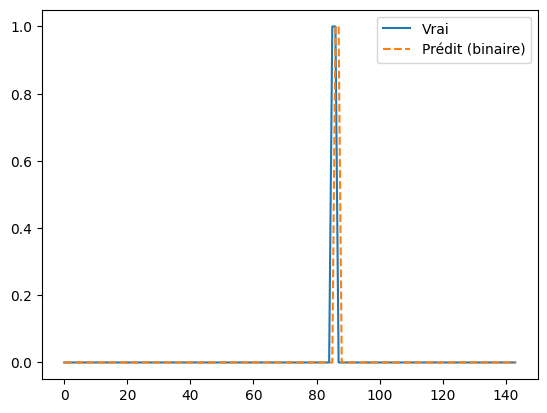

In [140]:

plt.plot(Y_test3[10].flatten(), label='Vrai')
plt.plot(Y_pred_binary3[10].flatten(), label='Prédit (binaire)', linestyle='--')
plt.legend()
plt.show()